## Copyright

    Done!
Checking exotethys database...
Checking ephemerides database...
Checking photometry database...
Checking catalogues database...

Enter RadialVelocityDatabase

Input the name of the stellar target. Do not include a planet designation.
What is the name of your target? HAT-P-23


Inflated RV uncertainties for HIRES by 248.726936 m/s73..-1028.0173]*| it/evals=8100/17263 eff=48.0342% N=400  0 0   0 0  
Inflated RV uncertainties for SOPHIE by 0.297151 m/s
nobs_lc =  42
nobs_rv =  2
nobs_emid =  5


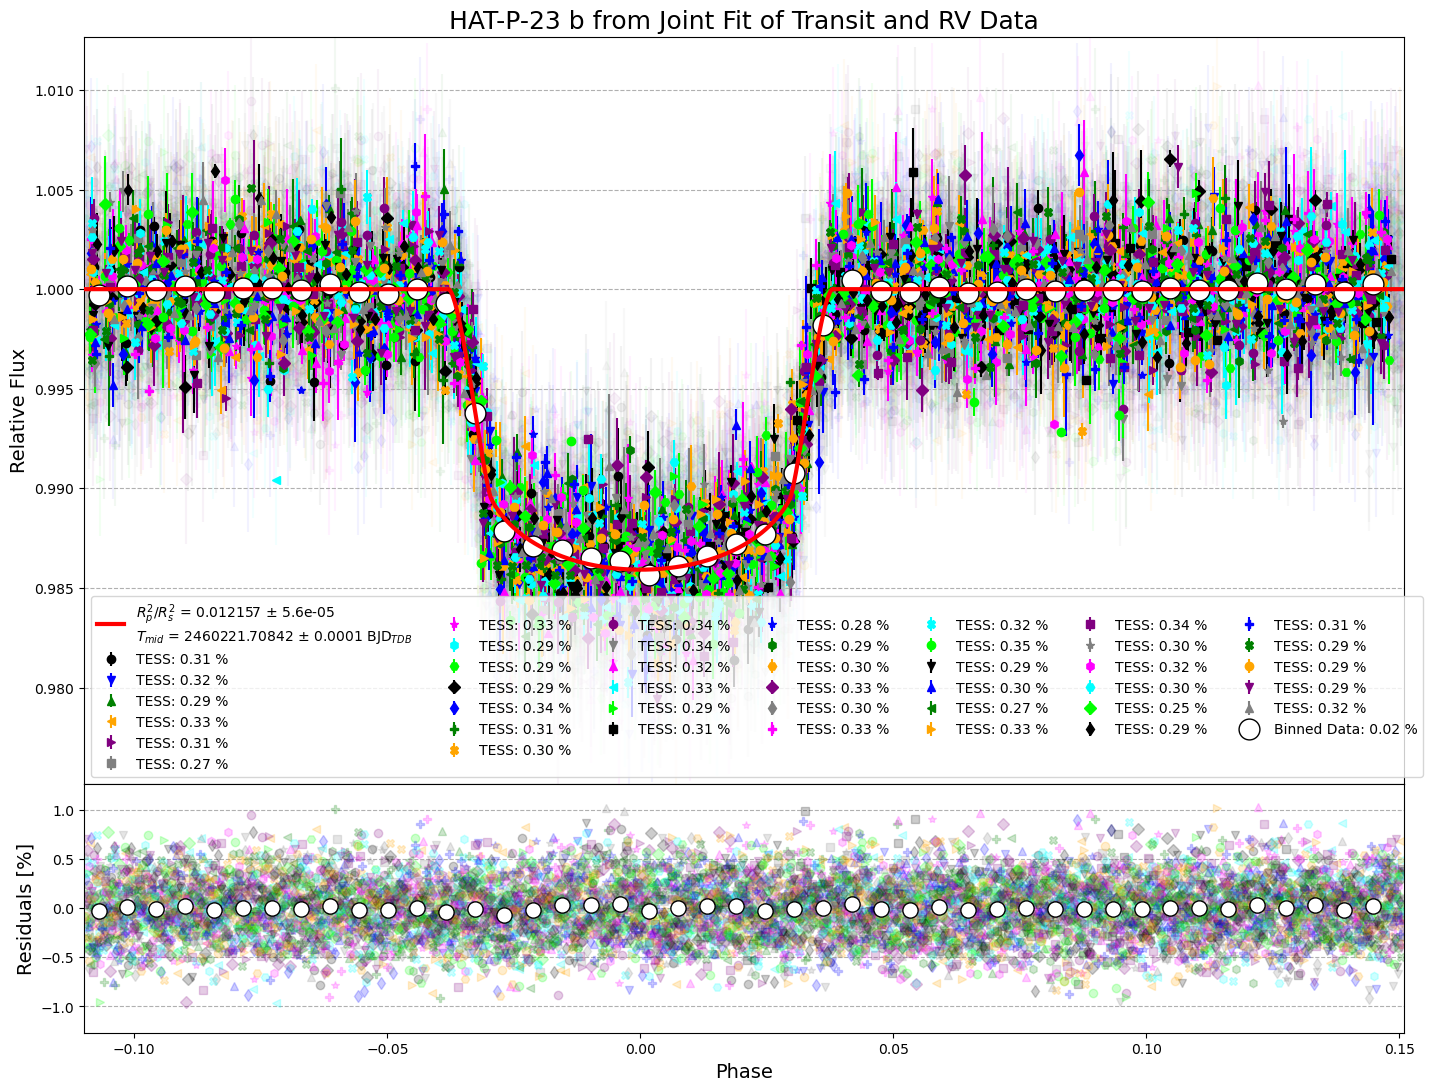

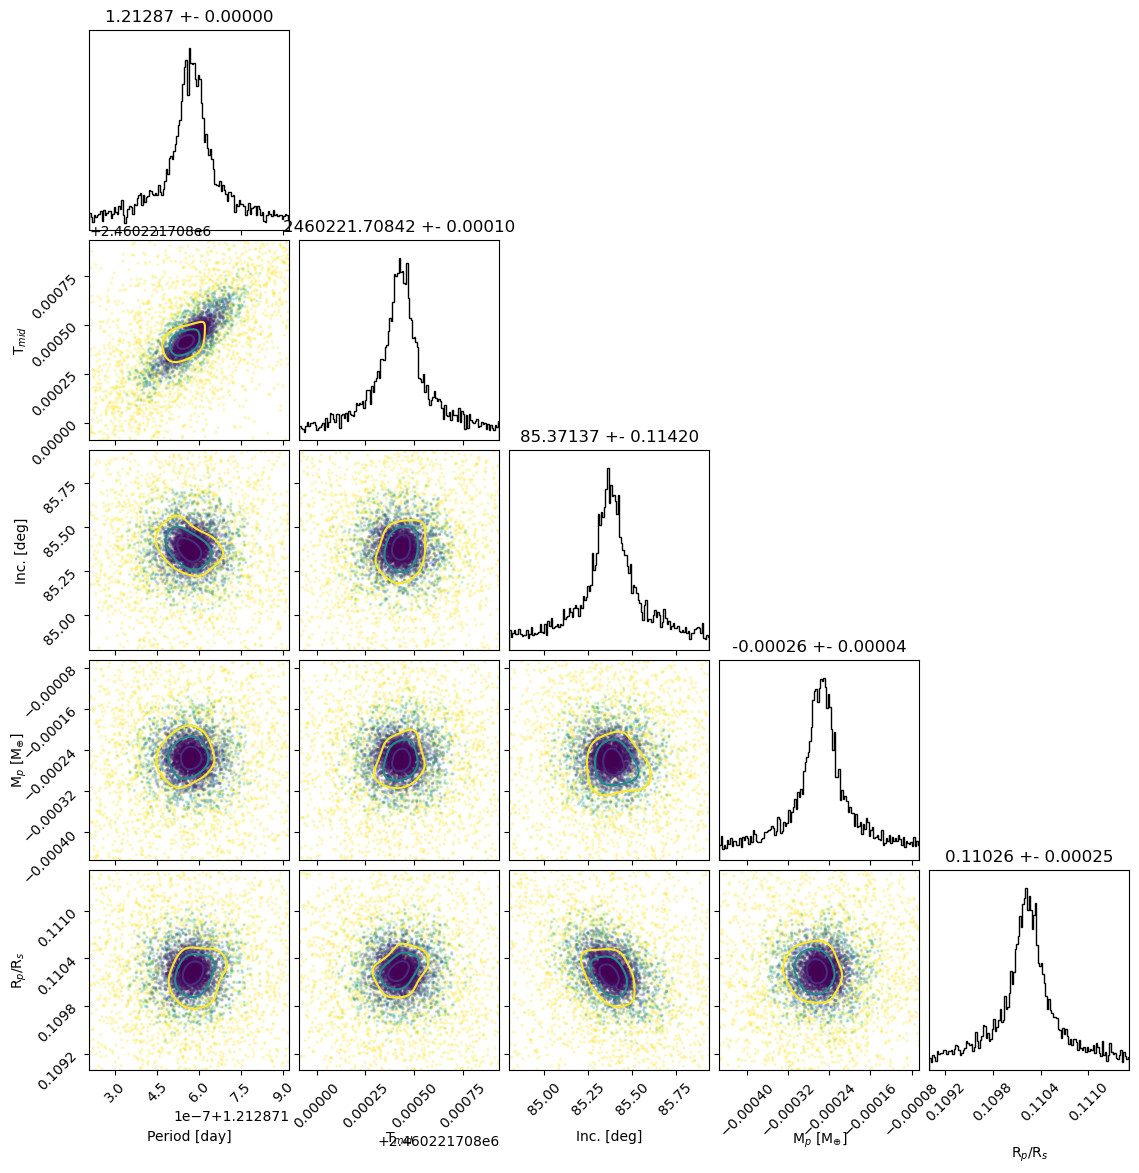

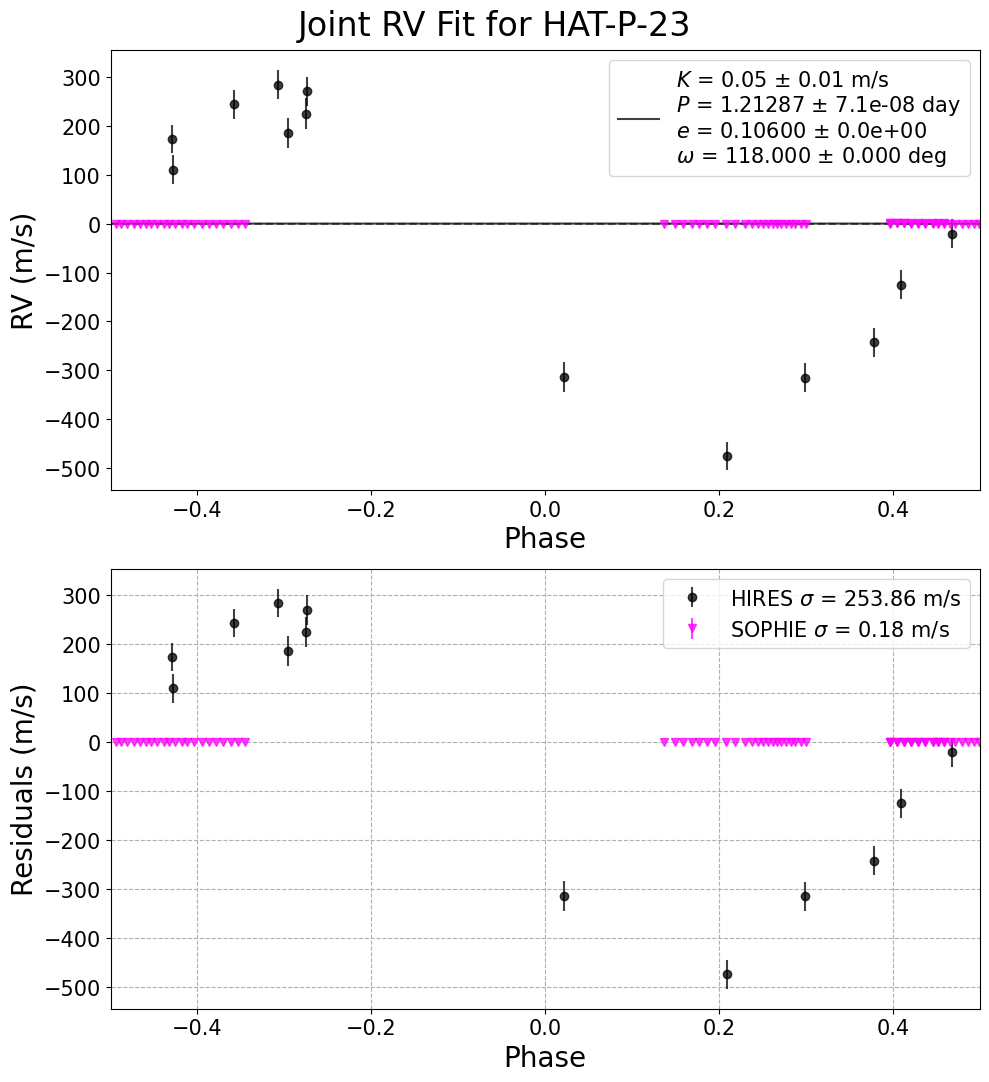

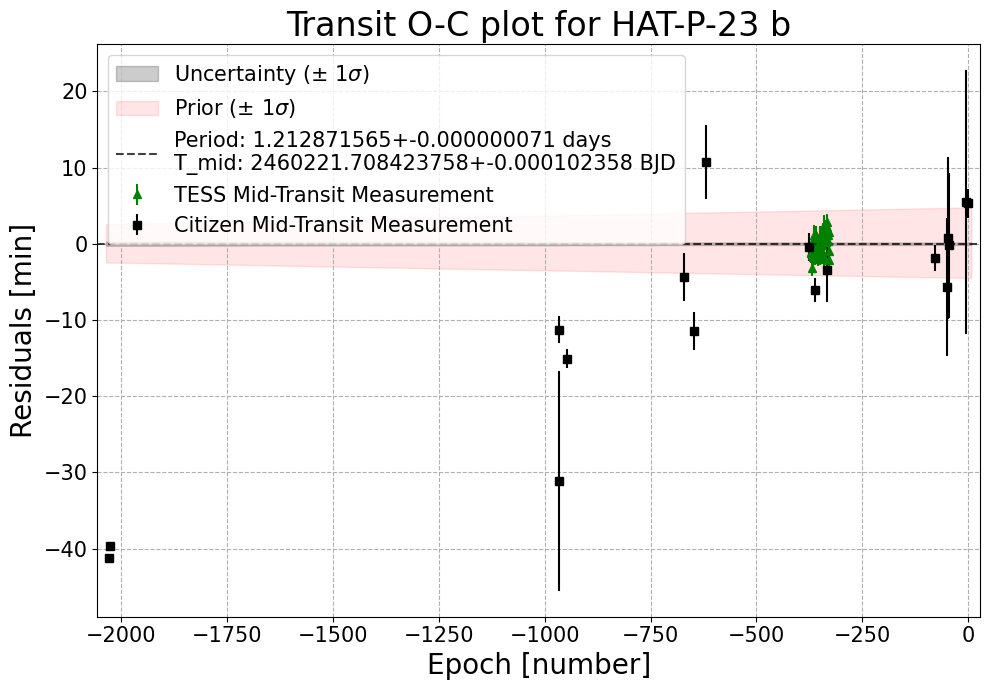

Eclipse Residual [min]: [ -8.68110158 -13.22226584 -10.87731913   1.47644877   2.87064828]


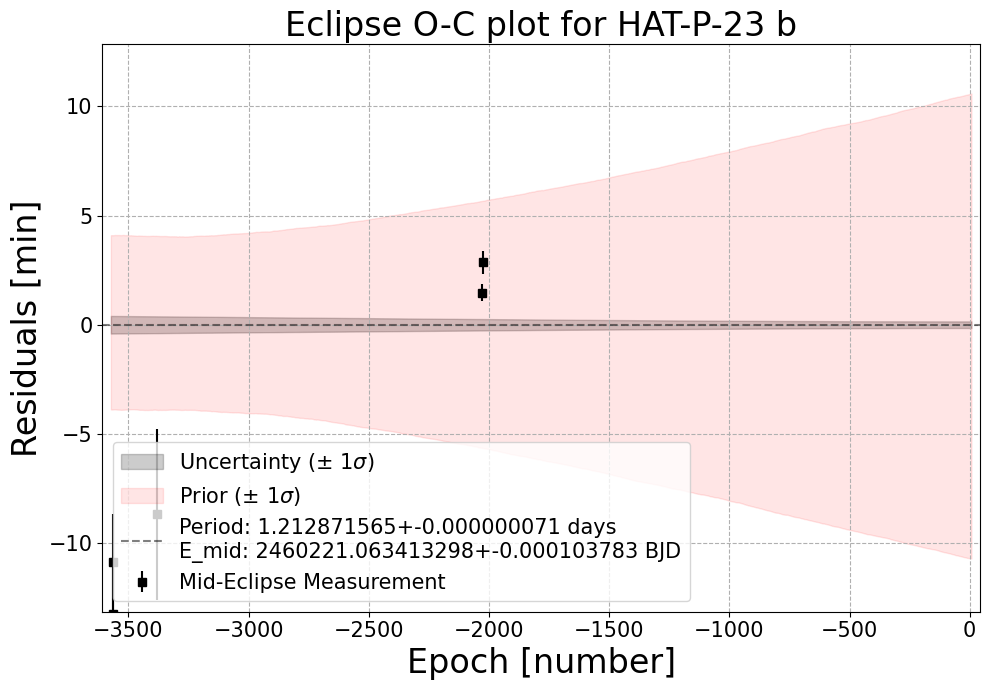

per & 1.212871565106570 $\pm$ 0.000000071183299 \\
tmid & 2460221.708423757459968 $\pm$ 0.000102357900231 \\
inc & 85.371368160615390 $\pm$ 0.114195931123050 \\
mplanet & -0.000259402309304 $\pm$ 0.000038913278548 \\
rprs & 0.110257807973978 $\pm$ 0.000252105124384 \\
HIRES_offset & 104.679980113368941 $\pm$ 0.001136819068157 \\
SOPHIE_offset & 1.808278667908775 $\pm$ 0.001659400011375 \\
ars & 4.143889402319266 $\pm$ 0.000000168144909 \\
a & 0.023183039464236 $\pm$ 0.000000000940689 \\
mu & -0.000000219354015 $\pm$ 0.000000032363343 \\
emid & 2460221.063413298688829 $\pm$ 0.000103782828814 \\
K & 0.045716164331423 $\pm$ 0.006746118510321 \\
T14 & 2.200054793007311 $\pm$ 0.144923124825069 \\
rprs2 & 0.012156784219227 $\pm$ 0.000055593116787 \\

Inflated RV uncertainties for HIRES by 248.726936 m/s
Inflated RV uncertainties for SOPHIE by 0.297151 m/s

The time to completion was 17.712 mins.


In [1]:
# ########################################################################### #
#    Copyright (c) 2019-2023, California Institute of Technology.
#    All rights reserved.  Based on Government Sponsored Research under
#    contracts NNN12AA01C, NAS7-1407 and/or NAS7-03001.
#
#    Redistribution and use in source and binary forms, with or without
#    modification, are permitted provided that the following conditions
#    are met:
#      1. Redistributions of source code must retain the above copyright
#         notice, this list of conditions and the following disclaimer.
#      2. Redistributions in binary form must reproduce the above copyright
#         notice, this list of conditions and the following disclaimer in
#         the documentation and/or other materials provided with the
#         distribution.
#      3. Neither the name of the California Institute of
#         Technology (Caltech), its operating division the Jet Propulsion
#         Laboratory (JPL), the National Aeronautics and Space
#         Administration (NASA), nor the names of its contributors may be
#         used to endorse or promote products derived from this software
#         without specific prior written permission.
#
#    THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS
#    "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT
#    LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR
#    A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE CALIFORNIA
#    INSTITUTE OF TECHNOLOGY BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL,
#    SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED
#    TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR
#    PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF
#    LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING
#    NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS
#    SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.
#
# ########################################################################### #
#    EXOplanet Transit Interpretation Code (EXOTIC)
#    # NOTE: See companion file version.py for version info.
# ########################################################################### #
# ########################################################################### #
# Exoplanet light curve analysis
#
# Fit an exoplanet transit model to time series data.
# ########################################################################### #
# this code is executed solely to record accurately the run time for this notebook
import time
start_time = time.time()

import copy
import pickle
import numpy as np
from itertools import cycle
from astropy.time import Time
import matplotlib.pyplot as plt
from astropy import units as u
from astropy import constants as const
from pylightcurve.models.exoplanet_lc import eclipse_mid_time, transit_flux_drop
from ultranest import ReactiveNestedSampler
from astroquery.ipac.nexsci.nasa_exoplanet_archive import NasaExoplanetArchive
from astroquery.simbad import Simbad
from scipy import stats
from copy import deepcopy
import glob

from math import sin,cos,tan,asin,acos,atan,radians,degrees,pi,log
from uncertainties import ufloat
from uncertainties.umath import *  # sin(), etc.

import os
import fnmatch
import pandas as pd
import matplotlib as mpl
import plotly
import plotly.express as px

from itertools import cycle
from dace_query.spectroscopy import Spectroscopy
from statistics import mean
from astropy.io import fits
from datetime import datetime
from exotic.api.elca import glc_fitter, lc_fitter
from exotic.api.rv_fitter import rv_fitter
#import exotic.api.rv
#from exotic.api.rv import RadialVelocityDatabase
import exotic.api.rv_csv
from exotic.api.rv_csv import rv_file_extract

import exotic.api.plotting

import logging
logger = logging.getLogger("ultranest")
logger.addHandler(logging.NullHandler())
logger.setLevel(logging.WARNING)
# this program log is used to record and retain information regarding the execution of this notebook
today = datetime.today().strftime('%Y%m%d%H%M')
logname = 'jointfitlog'+today+'.txt'
startstring = 'begin log for '+today
with open(logname, 'w') as joint_log:
    joint_log.write(startstring)
#Settings
AU = const.au.to(u.m).value
Mjup = const.M_jup.to(u.kg).value
Msun = const.M_sun.to(u.kg).value
Rsun = const.R_sun.to(u.m).value
Grav = const.G.to(u.m**3/u.kg/u.day**2).value

## Instruments
# set an empty array for the instruments from which observations will be successfully collected
instruments=[]

## Indicators
# stellar activity indicators are used to detect effects on radial velocity that could cause false positives
# for planetary perturbations
indicators = ['rhk']            # rhk is the default

## rhk_value
# rhk has been chosen as a default. If another activity indicator is present for the instrument chosen,
# the code must be modified in this notebook and the RV_Mapper
rhk_value = 3.00                # this value should be set to the published value for the star, if known

# other stellar activity indicators are:
# indicators = ['sindex']
# indicators = ['haindex']
# indicators = ['bispan']
# indicators = ['fwhm']
# indicators = ['contrast']
# indicators = ['rhk']
# if an indicator is chosen and is not present in the data for an instrument collected, the code will fail
clip_snr = 30.0         # This is the low bar for acceptable signal to noise ratios. 
                        # That is: (radial velocity/radial velocity uncertainties).

# end of variable setting for Radial Velocity observations

# ########################################################################### #

save_myfit_lc_parameters = []
save_myfit_lc_errors = []

def planet_orbit(period, sma_over_rs, eccentricity, inclination, periastron, mid_time, time_array, ww=0, mu=1, W=0):
    # please see original: https://github.com/ucl-exoplanets/pylightcurve/blob/master/pylightcurve/models/exoplanet_lc.py

    inclination = inclination * np.pi / 180.0
    periastron = periastron * np.pi / 180.0
    ww = ww * np.pi / 180.0
    W = W * np.pi / 180.0

    if eccentricity == 0 and ww == 0:
        vv = 2 * np.pi * (time_array - mid_time) / period
        bb = sma_over_rs * np.cos(vv)
        return [mu*bb * np.sin(inclination), mu*sma_over_rs * np.sin(vv), - bb * mu*np.cos(inclination)]

    if periastron < np.pi / 2:
        aa = 1.0 * np.pi / 2 - periastron
    else:
        aa = 5.0 * np.pi / 2 - periastron
    bb = 2 * np.arctan(np.sqrt((1 - eccentricity) / (1 + eccentricity)) * np.tan(aa / 2))
    if bb < 0:
        bb += 2 * np.pi
    mid_time = float(mid_time) - (period / 2.0 / np.pi) * (bb - eccentricity * np.sin(bb))
    m = (time_array - mid_time - np.int_((time_array - mid_time) / period) * period) * 2.0 * np.pi / period
    u0 = m
    stop = False
    u1 = 0
    for ii in range(10000):  # setting a limit of 1k iterations - arbitrary limit
        u1 = u0 - (u0 - eccentricity * np.sin(u0) - m) / (1 - eccentricity * np.cos(u0))
        stop = (np.abs(u1 - u0) < 10 ** (-6)).all()
        if stop:
            break
        else:
            u0 = u1
    if not stop:
        raise RuntimeError('Failed to find a solution in 10000 loops')

    vv = 2 * np.arctan(np.sqrt((1 + eccentricity) / (1 - eccentricity)) * np.tan((u1) / 2))
    rr = mu*sma_over_rs * (1 - (eccentricity ** 2)) / (np.ones_like(vv) + eccentricity * np.cos(vv+W))

    aa = np.cos(vv + periastron)
    bb = np.sin(vv + periastron)

    x = rr * bb * np.sin(inclination)
    y = rr * (-aa * np.cos(ww) + bb * np.sin(ww) * np.cos(inclination))
    z = rr * (-aa * np.sin(ww) - bb * np.cos(ww) * np.cos(inclination))

    return [x, y, z]

def pytransit(limb_darkening_coefficients, rp_over_rs, period, sma_over_rs, eccentricity, inclination, periastron,
            mid_time, time_array, method='claret', precision=3):

    position_vector = planet_orbit(period, sma_over_rs, eccentricity, inclination, periastron, mid_time, time_array)

    projected_distance = np.where(
        position_vector[0] < 0, 1.0 + 5.0 * rp_over_rs,
        np.sqrt(position_vector[1] * position_vector[1] + position_vector[2] * position_vector[2]))

    return transit_flux_drop(limb_darkening_coefficients, rp_over_rs, projected_distance,
                             method=method, precision=precision)

def transit(times, values):

    model = pytransit([values['u0'], values['u1'], values['u2'], values['u3']], 
                    values['rprs'], values['per'], values['ars'], 
                    values['ecc'], values['inc'], values['omega'],
                    values['tmid'], times, method='claret', precision=3)
    return model

from pylightcurve.models.exoplanet_lc import transit as pytransit
from pylightcurve.models.exoplanet_lc import eclipse_mid_time

def get_phase(times, per, tmid):

    return (times - tmid + 0.25 * per) / per % 1 - 0.25

def rv_model(time, params, dt=0.0001):

    xp,yp,zp = planet_orbit(params['per'], params['ars'], params['ecc'], 
                            params['inc'], params['omega'], params['tmid'], 
                            time, mu=1, ww=0)
    # TODO optimize by only computing in X direction
    xp2,yp2,zp2 = planet_orbit(params['per'], params['ars'], params['ecc'],
                            params['inc'], params['omega'], params['tmid'],
                            time+dt, mu=1, ww=0)
    # (const.R_sun / 0.0001 / u.day).to(u.m/u.s).value
    # scale in order to get sensible units
    return (xp2-xp)*params['mu']*params['rstar']*80520833.33333333 # Rstar/day -> m/s

# simultaneously fit multiple data sets with global and local parameters
class grv_fitter(glc_fitter):
    ns_type = 'ultranest'

    def __init__(self, lc_data, local_lc_bounds, rv_data, local_rv_bounds, global_bounds, ephemeris, individual_fit=True, verbose=False):
        # keys for input_data: time, flux, ferr, airmass, priors all numpy arrays
        self.lc_data = lc_data
        self.local_lc_bounds = local_lc_bounds
        self.rv_data = rv_data
        self.local_rv_bounds = local_rv_bounds
        self.individual_fit = individual_fit
        self.global_bounds = global_bounds
        self.ephemeris = ephemeris
        self.verbose = verbose        
        self.fit_nested()

    def fit_nested(self):

        # create bound arrays for generating samples
        nobs_lc = len(self.lc_data)
        print('nobs_lc = ',nobs_lc)
        nobs_rv = len(self.rv_data)
        print('nobs_rv = ',nobs_rv)
        nobs_emid = len(ephemeris['emid'])
        print('nobs_emid = ',nobs_emid)

        # fit individual light curves to constrain priors
        if self.individual_fit:
            for i in range(nobs_lc):

                print(f"Fitting individual light curve {i+1}/{nobs_lc}")
                mybounds = dict(**self.local_lc_bounds[i])#, **self.global_bounds)
                if 'inc' in self.global_bounds:
                    mybounds['inc'] = self.global_bounds['inc']
                if 'tmid' in self.global_bounds:
                    mybounds['tmid'] = self.global_bounds['tmid']

                myfit = lc_fitter(
                    self.lc_data[i]['time'],
                    self.lc_data[i]['flux'],
                    self.lc_data[i]['ferr'],
                    self.lc_data[i]['airmass'],
                    self.lc_data[i]['priors'],
                    mybounds
                )

                # update global bounds with +/- 5 sigma
                for j, key in enumerate(self.local_lc_bounds[i].keys()):
                    if 'rprs' in key:
                        self.local_lc_bounds[i][key] = [
                            max(0, myfit.parameters[key] - 10*myfit.errors[key]),
                            myfit.parameters[key] + 10*myfit.errors[key]
                        ]
                    else:
                        self.local_lc_bounds[i][key] = [
                            myfit.parameters[key] - 5*myfit.errors[key],
                            myfit.parameters[key] + 5*myfit.errors[key]
                        ]
                # if using gaussian prior on inclination
                if 'inc' in self.global_bounds:
                    self.global_bounds['inc'] = [
                        myfit.parameters['inc']- myfit.errors['inc']*10,
                        min(myfit.parameters['inc']+ myfit.errors['inc']*10, 90)
                    ]  

                save_myfit_lc_parameters.append(myfit.parameters)
                save_myfit_lc_errors.append(myfit.errors)
                print()
                
                del(myfit)

        # keys for global bounds
        gfreekeys = list(self.global_bounds.keys())

        # keys for local bounds
        lfreekeys = []
        boundarray = [self.global_bounds[k] for k in gfreekeys]
        alltime = [] # array for calling rv orbit eq once

        # collect RV data
        for i in range(nobs_rv):
            lfreekeys.append(list(self.local_rv_bounds[i].keys()))
            boundarray.extend([self.local_rv_bounds[i][k] for k in lfreekeys[-1]])
            alltime.extend(self.rv_data[i]['time'])
        alltime = np.array(alltime)
        dalltime = alltime - alltime.min()

        # collect LC data
        for i in range(nobs_lc):
            lfreekeys.append(list(self.local_lc_bounds[i].keys()))
            boundarray.extend([self.local_lc_bounds[i][k] for k in lfreekeys[-1]])
        boundarray = np.array(boundarray)

        # make global time array and time masks for each rv data set
        tmask = np.zeros(len(alltime), dtype=bool)
        idx = 0
        for i in range(nobs_rv):
            self.rv_data[i]['time_mask'] = tmask.copy()
            self.rv_data[i]['time_mask'][idx:idx+len(self.rv_data[i]['time'])] = True
            idx += len(self.rv_data[i]['time'])

        # transform unit cube to prior volume
        bounddiff = np.diff(boundarray,1).reshape(-1)

        # create a gaussian priors, if any
        gaussian_priors = {}
        for k in ['rstar','mstar']:
            if k in gfreekeys:
                gaussian_priors[k] = stats.norm(
                    self.global_bounds[k][0],
                    self.global_bounds[k][1])
                gaussian_priors[k+"_idx"] = gfreekeys.index(k)

            #    return gaussdistribution.ppf(quantile)
            def prior_transform(upars):
                newpars = (boundarray[:,0] + bounddiff*upars) # uniform
                for k in gaussian_priors.keys():
                    if 'idx' in k:
                        continue
                    newpars[gaussian_priors[k+"_idx"]] = gaussian_priors[k].ppf(upars[gaussian_priors[k+"_idx"]])

                return newpars

        # estimate orbit numbers for ephemeris
        if self.ephemeris is not None:
            self.ephemeris['tmid_orbit'] = np.round((self.ephemeris['tmid'][:,0]-self.ephemeris['prior']['tmid'][0])/self.ephemeris['prior']['per'][0])
            self.ephemeris['historic_orbit'] = np.round((self.ephemeris['historic'][:,0]-self.ephemeris['prior']['tmid'][0])/self.ephemeris['prior']['per'][0])
            self.ephemeris['emid_orbit'] = np.round((self.ephemeris['emid'][:,0]-self.ephemeris['prior']['emid'][0])/self.ephemeris['prior']['per'][0])

        def loglike(pars):
            
            rv_chi2 = 0  # radial velocity
            lc_chi2 = 0  # transit light curves
            eph_chi2 = 0 # ephemeris

            # set parameters
            for j, key in enumerate(gfreekeys):
                self.rv_data[0]['priors'][key] = pars[j]

            # compute mass ratio
            mtotal = Msun*self.rv_data[0]['priors']['mstar'] + \
                     Mjup*self.rv_data[0]['priors']['mplanet'] # kg
            mu = self.rv_data[0]['priors']['mplanet']*Mjup/(Msun*self.rv_data[0]['priors']['mstar'])

            # semi-major axis using Kepler's 3rd law
            semimajor = (Grav*mtotal*self.rv_data[0]['priors']['per']**2/4/np.pi**2)**(1/3) # m

            # estimate a/Rs
            ars = semimajor/(self.rv_data[0]['priors']['rstar']*Rsun)

            # priors should be the same, except for that first idx, we'll fix later
            self.rv_data[0]['priors']['ars'] = ars
            self.rv_data[0]['priors']['mu'] = mu

            # global rv model
            orbit = rv_model(alltime, self.rv_data[0]['priors'])

            # apply trend to RV data
            orbit += dalltime * self.rv_data[0]['priors']['rv_linear'] + \
                    self.rv_data[0]['priors']['rv_quad']*dalltime**2

            # for each RV dataset compute chi2
            for i in range(nobs_rv):

                # set global parameters
                self.rv_data[i]['priors']['mu'] = mu
                self.rv_data[i]['priors']['ars'] = ars

                for j, key in enumerate(gfreekeys):
                    self.rv_data[i]['priors'][key] = pars[j]

                # set local parameters - TODO remove or test
                ti = sum([len(self.local_rv_bounds[k]) for k in range(i)])
                for j, key in enumerate(lfreekeys[i]):
                    self.rv_data[i]['priors'][key] = pars[j+ti+len(gfreekeys)]

                # extract relevant part of the rv model
                model = orbit[self.rv_data[i]['time_mask']]

                # handle offset
                detrend = self.rv_data[i]['vel'] - model
                model += np.mean(detrend)

                # TODO add error scaling to chi2
                rv_chi2 += np.sum(((self.rv_data[i]['vel']-model)/(self.rv_data[i]['velerr']))**2)#/nobs_rv

            # for each LC dataset compute chi2
            for i in range(nobs_lc):

                # set global parameters
                self.lc_data[i]['priors']['mu'] = mu
                self.lc_data[i]['priors']['ars'] = ars

                for j, key in enumerate(gfreekeys):
                    self.lc_data[i]['priors'][key] = pars[j]

                # set local parameters
                ti = sum([len(self.local_lc_bounds[k]) for k in range(i)])
                for j, key in enumerate(lfreekeys[i+nobs_rv]):
                    self.lc_data[i]['priors'][key] = pars[j+ti+len(gfreekeys)]

                # compute lc model
                model = transit(self.lc_data[i]['time'], self.lc_data[i]['priors'])

                # handle offset
                detrend = self.lc_data[i]['flux']/model
                model *= np.mean(detrend)
                lc_chi2 += 2*np.sum(((self.lc_data[i]['flux']-model)/(self.lc_data[i]['ferr']))**2)

             # for each emid compute chi2
            for i in range(nobs_emid):               
                # add ephemeris into chi2
                self.ephemeris['tmid_orbit'] = np.round((self.ephemeris['tmid'][:,0]-self.lc_data[0]['priors']['tmid'])/self.rv_data[0]['priors']['per'])

                # predict mid-transit time
                tmid_pred = self.ephemeris['tmid_orbit']*self.rv_data[0]['priors']['per'] + self.lc_data[0]['priors']['tmid']
                eph_chi2 += np.sum(((tmid_pred-self.ephemeris['tmid'][:,0])/(self.ephemeris['tmid'][:,1]+self.ephemeris['noise']))**2)

                # predict mid-eclipse time [slow but accurate]
                emid = eclipse_mid_time(
                    self.rv_data[0]['priors']['per'], 
                    self.rv_data[0]['priors']['ars'], 
                    self.rv_data[0]['priors']['ecc'], 
                    self.lc_data[0]['priors']['inc'], 
                    self.rv_data[0]['priors']['omega'], 
                    self.lc_data[0]['priors']['tmid'])

                self.ephemeris['emid_orbit'] = np.round((self.ephemeris['emid'][:,0]-emid)/self.rv_data[0]['priors']['per'])

                # predict mid-ecliipse time
                emid_pred = self.ephemeris['emid_orbit']*self.rv_data[0]['priors']['per'] + emid
                
                eph_chi2 += np.sum(((emid_pred-self.ephemeris['emid'][:,0])/(self.ephemeris['emid'][:,1]))**2)

            # maximization metric for nested sampling
            return -0.5*(rv_chi2 + lc_chi2 + eph_chi2)

        # make labels for posterior plot
        freekeys = []+gfreekeys
        for n in range(nobs_rv+nobs_lc):
            for k in lfreekeys[n]:
                freekeys.append(f"local_{n}_{k}")
        
        if self.verbose:
            self.results = ReactiveNestedSampler(freekeys, loglike, prior_transform).run(max_ncalls=2e5)
        else:
            self.results = ReactiveNestedSampler(freekeys, loglike, prior_transform).run(max_ncalls=2e5, show_status=self.verbose, viz_callback=self.verbose)

        self.parameters = {}
        self.parameters_median = {}
        self.quantiles = {}
        self.errors = {}

        self.parameters = self.lc_data[0]['priors'].copy()
        for i, key in enumerate(freekeys):
            self.parameters[key] = self.results['maximum_likelihood']['point'][i]
            if key == 'rstar': self.parameters[key] = self.results['posterior']['median'][i]
            self.parameters_median[key] = self.results['posterior']['median'][i]

            self.errors[key] = self.results['posterior']['stdev'][i]
            self.quantiles[key] = [
                self.results['posterior']['errlo'][i],
                self.results['posterior']['errup'][i]]

        # compute some ratios
        mtotal = Msun*self.parameters.get('mstar', self.rv_data[0]['priors']['mstar']) + \
                 Mjup*self.parameters.get('mplanet', self.rv_data[0]['priors']['mplanet']) # kg
        mu = self.parameters.get('mplanet', self.rv_data[0]['priors']['mplanet'])*Mjup / \
                (self.parameters.get('mstar', self.rv_data[0]['priors']['mstar'])*Msun)

        # semi-major axis using Kepler's 3rd law
        semimajor = (Grav*mtotal*self.parameters['per']**2/4/np.pi**2)**(1/3) # m

        # estimate a/Rs
        ars = semimajor/(self.parameters.get('rstar', self.rv_data[0]['priors']['rstar'])*Rsun)

        for n in range(nobs_rv): # TODO
            self.rv_data[n]['errors'] = {}
            self.rv_data[n]['priors']['mu'] = mu
            self.rv_data[n]['priors']['ars'] = ars

            # set global parameters
            for k in gfreekeys:
                self.rv_data[n]['priors'][k] = self.parameters[k]
                self.rv_data[n]['errors'][k] = self.errors[k]

            # set local parameters
            for k in lfreekeys[n]:
                pkey = f"local_{n}_{k}"
                # replace with final parameters
                self.rv_data[n]['priors'][k] = self.parameters[pkey]
                self.rv_data[n]['errors'][k] = self.errors[pkey]

            dtime = self.rv_data[n]['time'] - alltime.min()
            self.rv_data[n]['model'] = rv_model(self.rv_data[n]['time'], self.rv_data[n]['priors']) + \
                dtime * self.parameters.get('rv_linear',0) + \
                dtime**2 * self.parameters.get('rv_quad',0)

            detrend = self.rv_data[n]['vel'] - self.rv_data[n]['model']
            self.rv_data[n]['priors']['offset'] = np.mean(detrend) # TODO use monte carlo
            self.rv_data[n]['detrend'] = self.rv_data[n]['vel'] - self.rv_data[n]['priors']['offset']
            self.rv_data[n]['residuals'] = self.rv_data[n]['detrend'] - self.rv_data[n]['model']

        # global up-scaled rv model
        self.rv_time = np.linspace(min(alltime), max(alltime), 100000)
        self.dalltime = self.rv_time - self.rv_time.min()
        rv = rv_model(self.rv_time, self.rv_data[0]['priors'])
        self.rv_model = rv + self.parameters.get('rv_linear',0)*self.dalltime + \
                             self.parameters.get('rv_quad',0)*self.dalltime**2
        self.rv_phase = (self.rv_time-self.parameters['tmid'])/self.parameters['per']

        time = []
        data = []
        detrended = []
        models = []
        for n in range(nobs_lc):
            self.lc_data[n]['errors'] = {}
            self.lc_data[n]['priors']['mu'] = mu
            self.lc_data[n]['priors']['ars'] = ars

            for k in gfreekeys:
                self.lc_data[n]['priors'][k] = self.parameters[k]
                self.lc_data[n]['errors'][k] = self.errors[k]

            for k in lfreekeys[n+nobs_rv]:
                pkey = f"local_{n+nobs_rv}_{k}"
                self.lc_data[n]['priors'][k] = self.parameters[pkey]
                self.lc_data[n]['errors'][k] = self.errors[pkey]
                if k == 'rprs' and 'rprs' not in freekeys:
                    self.parameters[k] = self.lc_data[n]['priors'][k]
                    self.errors[k] = self.lc_data[n]['errors'][k]

            model = transit(self.lc_data[n]['time'], self.lc_data[n]['priors'])
            airmass = np.exp(self.lc_data[n]['airmass']*self.lc_data[n]['priors']['a2'])
            detrend = self.lc_data[n]['flux']/(model*airmass)
            self.lc_data[n]['priors']['a1'] = np.mean(detrend)
            self.lc_data[n]['residuals'] = self.lc_data[n]['flux'] - model*airmass*self.lc_data[n]['priors']['a1']
            self.lc_data[n]['detrend'] = self.lc_data[n]['flux']/(airmass*self.lc_data[n]['priors']['a1'])
            self.lc_data[n]['model'] = model
            self.lc_data[n]['phase'] = get_phase(self.lc_data[n]['time'], self.parameters['tmid'], self.parameters['per'])
            time.extend(self.lc_data[n]['time'])
            data.extend(self.lc_data[n]['flux'])
            detrended.extend(detrend)
            models.extend(model)

        self.time = np.array(time)
        self.data = np.array(data)
        self.models = np.array(models)
        self.phase = (self.time-self.parameters['tmid'])/self.parameters['per']
        self.detrended = np.array(detrended)
        self.residuals = self.detrended - self.models

        self.mc_extras()
#####################################


    def mc_extras(self):        
        prior = self.rv_data[0]['priors'].copy()
        orbits = [] # rv model
        transits = []
        semi = []
        arss = []
        mratio = []
        eccs = []
        omegas = []
        emids = []

        offsets = {}
        for n in range(len(self.rv_data)):
            offsets[self.rv_data[n]['name']] = []

        # monte carlo over posteriors to derive offsets and a/Rs
        for n in range(1000):
            
            # randomize each parameter
            for i, key in enumerate(self.errors.keys()):
                try:
                    prior[key] = np.random.normal(self.parameters_median[key], self.errors[key])
                except:
                    pass

            # compute some ratios
            mtotal = Msun*prior['mstar'] + Mjup*prior['mplanet'] # kg
            mu = prior['mplanet']*Mjup/(Msun*prior['mstar'])

            # semi-major axis using Kepler's 3rd law
            semimajor = (Grav*mtotal*prior['per']**2/4/np.pi**2)**(1/3) # m

            # estimate a/Rs
            ars = semimajor/(prior['rstar']*Rsun)
            prior['ars'] = ars
            prior['mu'] = mu

            emid = eclipse_mid_time(
                    prior['per'], 
                    prior['ars'], 
                    prior['ecc'], 
                    prior['inc'], 
                    prior['omega'], 
                    prior['tmid']-prior['per'])
            
            emids.append(emid)
            orbits.append(rv_model(np.linspace(self.rv_time.min(), self.rv_time.min()+prior['per'], 10000), prior))
            semi.append(semimajor)
            arss.append(ars)
            mratio.append(mu)

            # derive rv offsets
            for n in range(len(self.rv_data)):

                dtime = self.rv_data[n]['time'] - self.rv_data[n]['time'].min()
                model = rv_model(self.rv_data[n]['time'], prior) + \
                    dtime * prior.get('rv_linear',0) + \
                    dtime**2 * prior.get('rv_quad',0)

                detrend = self.rv_data[n]['vel'] - model
                offsets[self.rv_data[n]['name']].append(np.mean(detrend))
            
            # estimate transit duration
            for n in range(len(self.lc_data)):
                model = transit(self.lc_data[n]['time'], prior)
                tmask = model < 1
                dt = np.diff(self.lc_data[n]['time']).mean()
                duration = tmask.sum()*dt
                transits.append(duration)

        for n in range(len(self.rv_data)):
            key = self.rv_data[n]['name']+"_offset"
            self.parameters[key] = np.mean(offsets[self.rv_data[n]['name']])
            self.errors[key] = np.std(offsets[self.rv_data[n]['name']])

        # a/Rs
        self.parameters['ars'] = np.median(arss)
        self.errors['ars'] = np.std(arss)

        # semimajor axis in AU
        self.parameters['a'] = np.median(semi)/AU
        self.errors['a'] = np.std(semi)/AU

        # mass ratio Mp/Ms
        self.parameters['mu'] = np.median(mratio)
        self.errors['mu'] = np.std(mratio)

        # mid -eclipse 
        self.parameters['emid'] = np.median(emids)
        self.errors['emid'] = np.std(emids)

        # rv semi-amplitude m/s
        orbit_K = (np.max(orbits,1) - np.min(orbits,1))/2
        self.parameters['K'] = np.median(orbit_K)
        self.errors['K'] = np.std(orbit_K)
        
        # duration in days
        ################################################
        self.parameters['T14'] = np.median(transits)*24              #convert to hours
        self.errors['T14'] = np.std(transits)*24                     #convert to hours

        self.parameters['rprs2'] = self.parameters['rprs']**2
        self.errors['rprs2'] = 2*self.parameters['rprs']*self.errors['rprs']

    def plot_rv_bestfit(self):
        
        fig, ax = plt.subplots(2,figsize=(10,11))

        markers = cycle(['o','v','^','<','>','s','*','h','H','D','d','P','X'])
        colors = cycle(['black','magenta','blue','cyan','lime','gold','red',])

        for n in range(len(self.rv_data)):
            phase = (self.rv_data[n]['time'] - self.rv_data[n]['priors']['tmid'])/self.parameters['per']
            phase += 0.5
            phase %= 1
            phase -= 0.5
            ncolor = next(colors)
            nmarker = next(markers)

            ax[0].errorbar(phase, self.rv_data[n]['detrend'], yerr=self.rv_data[n]['velerr'], 
                        marker=nmarker, color=ncolor,alpha=0.75, ls='')
            ax[1].errorbar(phase, self.rv_data[n]['residuals'], yerr=self.rv_data[n]['velerr'], 
                        marker=nmarker, color=ncolor,alpha=0.75, ls='', label=rf"{self.rv_data[n]['name']} $\sigma$ = {np.std(self.rv_data[n]['residuals']):.2f} m/s")

        plt_title = 'Joint RV Fit for '+target_planet
        plt.title(plt_title,fontsize=24)
        ax[0].axhline(0, color='k', ls='--', alpha=0.5)
        ax[0].set_xlim([-0.5,0.5])
        ax[1].set_xlim([-0.5,0.5])

        nphase = (self.rv_phase+0.5)%1-0.5
        si = np.argsort(nphase)

        label = rf"$K$ = {self.parameters['K']:.2f} $\pm$ {self.errors['K']:.2f} m/s" + "\n" \
                rf"$P$ = {self.parameters['per']:.5f} $\pm$ {self.errors['per']:.1e} day" + "\n" \
                rf"$e$ = {self.rv_data[0]['priors']['ecc']:.5f} $\pm$ {self.errors.get('ecc',0):.1e}" + "\n" \
                rf"$\omega$ = {self.rv_data[0]['priors']['omega']:.3f} $\pm$ {self.errors.get('omega',0):.3f} deg"
        ax[0].plot(nphase[si], self.rv_model[si], 'k-', label=label, alpha=0.75, zorder =2)

        ax[0].set_xlabel(f'BJD-{int(self.rv_time.min())}',fontsize=20)
        ax[0].set_ylabel("RV (m/s)",fontsize=20)

        ax[1].set_ylabel("Residuals (m/s)",fontsize=20)

        ax[0].set_xlabel("Phase",fontsize=20)
        ax[1].set_xlabel("Phase",fontsize=20)
        ax[1].grid(ls='--')

        ax[1].legend(fontsize="15",loc='upper right')             # Molly fix

        ax[0].legend(fontsize="15",loc='upper right')             # Molly fix
        ax[0].tick_params(axis='both', labelsize=15)      # Molly fix
        ax[1].tick_params(axis='both', labelsize=15)      # Molly fix
        plt_title = 'Joint RV Fit for '+target
        plt.suptitle(plt_title,fontsize=24)

        plt.title('')
        plt.tight_layout()

        return fig, ax

    def plot_oc_transits(self):
        
        markers = cycle(['o','v','^','<','>','s','*','h','H','D','d','P','X'])
        colors = cycle(['black','magenta','blue','cyan','lime','gold','red',])

        ############### O-C plot
        fig,ax = plt.subplots(1, figsize=(10,7))
        self.ephemeris['tmid_orbit'] = np.round((self.ephemeris['tmid'][:,0]-self.lc_data[0]['priors']['tmid'])/self.rv_data[0]['priors']['per'])
        self.ephemeris['historic_orbit'] = np.round((self.ephemeris['historic'][:,0]-self.lc_data[0]['priors']['tmid'])/self.rv_data[0]['priors']['per'])
        
        # predict mid-transit time
        tmid_pred = self.ephemeris['tmid_orbit']*self.rv_data[0]['priors']['per'] + self.lc_data[0]['priors']['tmid']
        tmid_residual = self.ephemeris['tmid'][:,0] - tmid_pred
        historic_pred = self.ephemeris['historic_orbit']*self.rv_data[0]['priors']['per'] + self.lc_data[0]['priors']['tmid']
        historic_residual = self.ephemeris['historic'][:,0] - historic_pred

        ax.errorbar(self.ephemeris['historic_orbit'], historic_residual*24*60, yerr=self.ephemeris['historic'][:,1]*24*60, ls='none', marker='^',label='TESS Mid-Transit Measurement',color='green')
        
        ax.errorbar(self.ephemeris['tmid_orbit'], tmid_residual*24*60, yerr=self.ephemeris['tmid'][:,1]*24*60, ls='none', marker='s',label='Citizen Mid-Transit Measurement',color='black')
        ylower = (tmid_residual.mean()-3*np.std(tmid_residual))*24*60
        yupper = (tmid_residual.mean()+3*np.std(tmid_residual))*24*60

        # upsample data
        epochs = (np.linspace(self.ephemeris['tmid_orbit'].min()-7, self.ephemeris['tmid_orbit'].max()+7, 1000)) 

        depoch = epochs.max() - epochs.min()
        ax.set_xlim([epochs.min()-depoch*0.01, epochs.max()+depoch*0.01])

        # best fit solution
        model = epochs*self.rv_data[0]['priors']['per'] + self.lc_data[0]['priors']['tmid']

        # MonteCarlo the new ephemeris for uncertainty
        mc_m = np.random.normal(self.parameters['per'], self.errors['per'], size=10000)
        mc_b = np.random.normal(self.parameters['tmid'], self.errors['tmid'], size=10000)
        mc_model = np.expand_dims(epochs,-1) * mc_m + mc_b

        # create a fill between area for uncertainty of new ephemeris
        diff = mc_model.T - model
        ax.fill_between(epochs, np.percentile(diff,16,axis=0)*24*60, np.percentile(diff,84,axis=0)*24*60, alpha=0.2, color='k', label=r'Uncertainty ($\pm$ 1$\sigma$)')

        # duplicate axis and plot days since mid-transit
        xticks = ax.get_xticks()
        dt = np.round(xticks*self.parameters['per'],1)
        show_2sigma = False

        if self.ephemeris['prior'] is not None:
            # create fill between area for uncertainty of old/prior ephemeris
            epochs_p = ((epochs*self.rv_data[0]['priors']['per'] + self.lc_data[0]['priors']['tmid']) - self.ephemeris['prior']['tmid'][0])/self.ephemeris['prior']['per'][0]
            #epochs_p = (np.linspace(self.ephemeris['tmid'][:,0].min()-7, self.ephemeris['tmid'][:,0].max()+7, 1000) 
            prior_p = epochs_p*self.ephemeris['prior']['per'][0] + self.ephemeris['prior']['tmid'][0]
            mc_m_p = np.random.normal(self.ephemeris['prior']['per'][0], self.ephemeris['prior']['per'][1], size=10000)
            mc_b_p = np.random.normal(self.ephemeris['prior']['tmid'][0], self.ephemeris['prior']['tmid'][1], size=10000)
            mc_model_p = np.expand_dims(epochs_p,-1) * mc_m_p + mc_b_p
            diff_p = mc_model_p.T - model

            if show_2sigma:
                ax.fill_between(epochs, np.percentile(diff_p,2,axis=0)*24*60, np.percentile(diff_p,98,axis=0)*24*60, alpha=0.1, color='r', label=r'Prior ($\pm$ 2$\sigma$)')
            else:
                # show ~1 sigma
                ax.fill_between(epochs, np.percentile(diff_p,36,axis=0)*24*60, np.percentile(diff_p,64,axis=0)*24*60, alpha=0.1, color='r', label=r'Prior ($\pm$ 1$\sigma$)')

        ax.axhline(0,color='black',alpha=0.75,ls='--',
                    label="Period: {:.9f}+-{:.9f} days\nT_mid: {:.9f}+-{:.9f} BJD".format(self.parameters['per'], self.errors['per'], np.round(self.parameters['tmid'],9), np.round(self.errors['tmid'],9)))

        ax.legend(fontsize="15",loc='best')             # Molly fix
        ax.set_xlabel("Epoch [number]",fontsize=20)
        ax.set_ylabel("Residuals [min]",fontsize=20)
        ax.tick_params(axis='both', labelsize=15)       # Molly fix
        plt_title = 'Transit O-C plot for '+target_planet
        plt.title(plt_title,fontsize=24)        
        ax.grid(True, ls='--')
        plt.tight_layout()
        return fig

    def plot_oc_eclipses(self):

        # O-C plot eclipse times
        fig,ax = plt.subplots(1, figsize=(10,7))

        # predict mid-eclipse time
        emid = self.parameters['emid']

        self.ephemeris['emid_orbit'] = np.round((self.ephemeris['emid'][:,0]-emid)/self.rv_data[0]['priors']['per'])

        # predict mid-transit time
        emid_pred = self.ephemeris['emid_orbit']*self.rv_data[0]['priors']['per'] + emid
        emid_residual = self.ephemeris['emid'][:,0] - emid_pred

        self.ephemeris['emid_orbit'] = np.round((self.ephemeris['emid'][:,0]-emid)/self.rv_data[0]['priors']['per'])

        emid_pred = self.ephemeris['emid_orbit']*self.rv_data[0]['priors']['per'] + emid
        emid_residual = self.ephemeris['emid'][:,0] - emid_pred

        print("Eclipse Residual [min]:", emid_residual*24*60)
        
        ax.errorbar(self.ephemeris['emid_orbit'], emid_residual*24*60, yerr=self.ephemeris['emid'][:,1]*24*60, ls='none', marker='s',label='Mid-Eclipse Measurement',color='black')
        ylower = (emid_residual.mean()-3*np.std(emid_residual))*24*60
        yupper = (emid_residual.mean()+3*np.std(emid_residual))*24*60

        # upsample data
        epochs = (np.linspace(self.ephemeris['emid_orbit'].min()-7, max(7,self.ephemeris['emid_orbit'].max()+7), 1000))

        depoch = epochs.max() - epochs.min()
        ax.set_xlim([epochs.min()-depoch*0.01, epochs.max()+depoch*0.01])

        # best fit solution
        model = epochs*self.parameters['per'] + emid

        # MonteCarlo the new ephemeris for uncertainty
        mc_m = np.random.normal(self.parameters['per'], self.errors['per'], size=10000)
        mc_b = np.random.normal(self.parameters['emid'], self.errors['emid'], size=10000)
        mc_model = np.expand_dims(epochs,-1) * mc_m + mc_b

        # create a fill between area for uncertainty of new ephemeris
        diff = mc_model.T - model
        ax.fill_between(epochs, np.percentile(diff,16,axis=0)*24*60, np.percentile(diff,85,axis=0)*24*60, alpha=0.2, color='k', label=r'Uncertainty ($\pm$ 1$\sigma$)')

        # duplicate axis and plot days since mid-transit                      
        xticks = ax.get_xticks()
        dt = np.round(xticks*self.parameters['per'],1)
        show_2sigma = False

        if self.ephemeris['prior'] is not None:
            # create fill between area for uncertainty of old/prior ephemeris
            epochs_p = ((epochs*self.rv_data[0]['priors']['per'] + emid) - self.ephemeris['prior']['emid'][0])/self.ephemeris['prior']['per'][0]
            prior_p = epochs_p*self.ephemeris['prior']['per'][0] + self.ephemeris['prior']['tmid'][0]
            mc_m_p = np.random.normal(self.ephemeris['prior']['per'][0], self.ephemeris['prior']['per'][1], size=10000)
            mc_b_p = np.random.normal(self.ephemeris['prior']['emid'][0], self.ephemeris['prior']['emid'][1], size=10000)
            mc_model_p = np.expand_dims(epochs_p,-1) * mc_m_p + mc_b_p
            diff_p = mc_model_p.T - model

            # plot an invisible line so the 2nd axes are happy

            if show_2sigma:
                ax.fill_between(epochs, np.percentile(diff_p,2,axis=0)*24*60, np.percentile(diff_p,98,axis=0)*24*60, alpha=0.1, color='r', label=r'Prior ($\pm$ 2$\sigma$)')
            else:
                # show ~1 sigma
                ax.fill_between(epochs, np.percentile(diff_p,16,axis=0)*24*60, np.percentile(diff_p,85,axis=0)*24*60, alpha=0.1, color='r', label=r'Prior ($\pm$ 1$\sigma$)')

            ax.set_ylim([ 0.5*(min(np.percentile(diff,1,axis=0)*24*60) + min(np.percentile(diff_p,1,axis=0)*24*60)),
                            0.5*(max(np.percentile(diff,99,axis=0)*24*60) + max(np.percentile(diff_p,99,axis=0)*24*60))])

        ax.axhline(0,color='black',alpha=0.5,ls='--',
                    label="Period: {:.9f}+-{:.9f} days\nE_mid: {:.9f}+-{:.9f} BJD".format(self.parameters['per'], self.errors['per'], np.round(emid,9), np.round(self.errors['emid'],9)))


        ax.legend(fontsize="15",loc='lower left')             # Molly fix
        ax.set_xlabel("Epoch [number]",fontsize=24)
        ax.set_ylabel("Residuals [min]",fontsize=24)
        ax.tick_params(axis='both', labelsize=15)             # Molly fix
        plt_title = 'Eclipse O-C plot for '+target_planet
        plt.title(plt_title,fontsize=24)
        ax.grid(True, ls='--')
        plt.tight_layout()
        return fig

# data translation from generic to rv fitter format

if __name__ == "__main__":
    
    # Target set-up
    print()
    print("Enter RadialVelocityDatabase")
    print()              
    print("Input the name of the stellar target. Do not include a planet designation.")
    target = input("What is the name of your target? ")
    simbad_result_count=0
    while simbad_result_count == 0:
        try:
            result_table = Simbad.query_object(target)
            simbad_result_count = len(result_table)
        except:
            simbad_result_count = 0
            print("Target not found.")
            target = input("What is the name of your target? ")
            
#    new_rv_data = RadialVelocityDatabase(target)  #this line can be uncommented and used rather than the following line
    new_rv_data = rv_file_extract(target)
    df = new_rv_data.get_data(target)

    target = df['target'][0]
    target_planet = target+' b'

    #Read priors from file
    prior = {}
    priorerr = {}
    file_namep = target+'priors.csv'
    myfilepriors = open (file_namep, 'r')
    for line in myfilepriors:
        values = line.split(',')
        key_name = values[0]
        priors_value1 = float(values[1])
        priors_value2 = float(values[2])
        prior[key_name] = priors_value1
        priorerr[key_name] = priors_value2

    # historical and literature values from file
    
    ephemeris = {}
    ephemeris['prior'] = {}
    ephemeris['noise'] = 0
    file_namet = target+'tmidarray.csv'
    file_namee = target+'emidarray.csv'
    file_nameh = target+'TESSarray.csv'
    file_namepr = target+'priorsarray.csv'
    myfiletmids = open (file_namet, 'r')
    myfileemids = open (file_namee, 'r')
    myfileTESS = open (file_nameh, 'r')
    myfilehpriors = open (file_namepr, 'r')
    i = 0
    for line in myfiletmids:
        values = line.split(',')
        value1 = float(values[0])
        value2 = float(values[1])
        workarray = [value1,value2]
        if i == 0:
            ephemeris['tmid'] = [workarray]
            i += 1
        else:
            ephemeris['tmid'].append(workarray)
    ephemeris['tmid']=np.array(ephemeris['tmid'])        
    i = 0
    for line in myfileemids:
        values = line.split(',')
        value1 = float(values[0])
        value2 = float(values[1])
        workarray = [value1,value2]
        if i == 0:
            ephemeris['emid'] = [workarray]
            i += 1
        else:
            ephemeris['emid'].append(workarray)
    ephemeris['emid']=np.array(ephemeris['emid'])        
    i = 0        
    for line in myfileTESS:
        values = line.split(',')
        value1 = float(values[0])
        value2 = float(values[1])
        workarray = [value1,value2]
        if i == 0:
            ephemeris['historic'] = [workarray]
            i += 1
        else:
            ephemeris['historic'].append(workarray)
    ephemeris['historic']=np.array(ephemeris['historic'])        
    for line in myfilehpriors:
        values = line.split(',')
        key_name = values[0]
        priors_value1 = float(values[1])
        priors_value2 = float(values[2])
        ephemeris['prior'][key_name] = [priors_value1,priors_value2]

    # check emid key exists
    if 'emid' not in ephemeris.keys():
        # estimate the historical eclipse time
        emids = []
        default = prior.copy()
        print("computing mid-eclipse prior + uncertainty...")
        for i in range(4444):
            for k in ephemeris['prior'].keys():
                default[k] = np.random.normal(ephemeris['prior'][k][0], ephemeris['prior'][k][1])
            default['ars'] = default['a'] * AU / (default['rstar'] * Rsun)
            emid = eclipse_mid_time(default['per'], default['ars'], default['ecc'], default['inc'], default['omega'], default['tmid'])
            #emids.append(emid+default['per']*41)
            emids.append(emid-default['per'])
        ephemeris['prior']['emid'] = [np.mean(emids), np.std(emids)]
        print(ephemeris['prior']['emid'])

    # add a constant noise term to reduce influence
    ephemeris['noise'] = ephemeris['tmid'][:,1].mean()/2

    # compute some ratios
    prior['mu'] = prior['mplanet']*Mjup / (prior['mstar']*Msun)
    mtotal = Msun*prior['mstar'] + \
                Mjup*prior['mplanet'] # kg

    # semi-major axis using Kepler's 3rd law
    semimajor = (Grav*mtotal*prior['per']**2/4/np.pi**2)**(1/3) # m

    # estimate a/Rs
    prior['ars'] = semimajor/(prior['rstar']*Rsun)

    # precompute mid-eclipse time
    emid = eclipse_mid_time(prior['per'], prior['ars'], prior['ecc'], prior['inc'], prior['omega'], prior['tmid'])
    emid -= prior['per'] # subtract one period so it's close to the real tmid

    rv_data = []
    local_rv_bounds = []

    # add RV data and separate into individual datasets
    for tele in df.Telescope.unique():
        
        # special case
        if tele == 'HRS': # break into two distributions
            df_tel = df[df.Telescope == tele]
            errors = df_tel['ErrVel(m/s)'].values # plot histogram to see multiple modes
            pop1 = errors < 5

            rv_data.append({
                'time':df_tel['BJD'].values[pop1],
                'vel':df_tel['Vel(m/s)'].values[pop1],
                'velerr':df_tel['ErrVel(m/s)'].values[pop1],
                'priors':prior.copy(),
                'name':tele+"_1"
            })
            local_rv_bounds.append({}) # not used but required data structure

            rv_data.append({
                'time':df_tel['BJD'].values[~pop1],
                'vel':df_tel['Vel(m/s)'].values[~pop1],
                'velerr':df_tel['ErrVel(m/s)'].values[~pop1],
                'priors':prior.copy(),
                'name':tele+"_2"
            })
            local_rv_bounds.append({}) # not used but required data structure
        else:
                
            df_tel = df[df.Telescope == tele]
            rv_data.append({
                'time':df_tel['BJD'].values,
                'vel':df_tel['Vel(m/s)'].values,
                'velerr':df_tel['ErrVel(m/s)'].values,
                'priors':prior.copy(),
                'name':tele
            })

        local_rv_bounds.append({}) # not used but required data structure, sometimes used for fitting jitter

    # specify bounds for fitting - all uniform distributions

        tmid_sigma = 200
        per_sigma = 500
        inc_sigma = 5
        omega_sigma = 5
        ecc_sigma = 5
        Mp_sigma = 20
        tmid_lower = prior['tmid']-((priorerr['tmid'])*tmid_sigma)          
        tmid_upper = prior['tmid']+((priorerr['tmid'])*tmid_sigma)          
        per_lower = prior['per']-((priorerr['per'])*per_sigma)
        per_upper = prior['per']+((priorerr['per'])*per_sigma)        
        inc_lower = prior['inc']-((priorerr['inc'])*inc_sigma)
        inc_upper = 90                                         # 90° maximum
        omega_lower = prior['omega']-((priorerr['omega'])*omega_sigma)
        omega_upper = prior['omega']+((priorerr['omega'])*omega_sigma)
        ecc_lower = prior['ecc']-((priorerr['ecc'])*ecc_sigma)
        ecc_upper = prior['ecc']+((priorerr['ecc'])*ecc_sigma)
        Mp_lower = prior['mplanet']-((priorerr['mplanet'])*Mp_sigma)
        Mp_upper = prior['mplanet']+((priorerr['mplanet'])*Mp_sigma)


        global_bounds = {
        'per':[per_lower,per_upper],                           # Bakos 2010
        'tmid':[tmid_lower, tmid_upper],                       # MBEB
        'inc':[inc_lower,inc_upper],                           # Bakos 2010
        'mplanet':[Mp_lower,Mp_upper]                          # Bakos 2010 M_Jupiter  
    }
        
    # set up transit data
    
    lc_data = []
    local_lc_bounds = []
    
    # TESS extracted light curve
    tessfileaddress = target+'_TESSfiles/*_AAVSO.txt'
    tess_files = glob.glob(tessfileaddress)

    for tf in tess_files:
        tess = np.loadtxt(tf, delimiter=',', skiprows=60)
        
    # tess data
    
        lc_data.append({
            'time':tess[:,0],
            'flux':tess[:,1],
            'ferr':tess[:,2],
            'airmass':np.zeros(tess.shape[0]),
            'priors':prior.copy(),
            'name':'TESS'
        })

    # perform a local LC fit to constrain inclination, Rp/Rs and Tmid
        local_lc_bounds.append({})

    # perform a global fit to constrain RV
    rv_only_bounds = {
        'per':[per_lower,per_upper],                 # Bakos 2010
#        'omega':[omega_lower,omega_upper],           # Bakos 2010
#        'ecc':[ecc_lower,ecc_upper],                 # Bakos 2010
        'mplanet':[Mp_lower,Mp_upper],               # Bakos 2010 M_Jupiter
    }

    # constrain the priors by fitting only the rv data first
    rvfit = rv_fitter(rv_data, rv_only_bounds, local_rv_bounds, verbose=True)

    for key in rvfit.parameters.keys():
        prior[key] = rvfit.parameters[key]

    # inflate uncertainties for each data set such that the average error is similar to the stdev of residuals
    for i, data in enumerate(rv_data):
        diff = max(0, rvfit.data[i]['residuals'].std() - rvfit.data[i]['velerr'].mean())
        rv_data[i]['velerr'] = rvfit.data[i]['velerr'] + 0.1*diff # should really be 0.5
        print(f"Inflated RV uncertainties for {rv_data[i]['name']} by {diff:2f} m/s")
        rv_data[i]['diff'] = diff

    # update light curve priors based on rv fit
    for lc in lc_data:
        for key in rvfit.parameters:
            lc['priors'][key] = rvfit.parameters[key]        

    # update rv priors based on rv fit
    for rv in rv_data:
        for key in rvfit.parameters:
            rv['priors'][key] = rvfit.parameters[key]
    global_bounds['rprs']=[0.0,0.2]
    
    # run global fit
    myfit = grv_fitter(lc_data, local_lc_bounds, rv_data, local_rv_bounds, 
                        global_bounds, ephemeris,
                        verbose=True, individual_fit=False
                      )
    
    #Plot timeseries
    import plotly
datemin=50000.000
datemax=60000.000
i=0
rv_rjd = []
rv_rv = []
rv_ins = []
while i < len(df["rjd"]):
    if df["rjd"][i] >= datemin and df["rjd"][i]<=datemax:
        rv_rjd.append(df["rjd"][i])
        rv_rv.append(df["rv"][i])
        rv_ins.append(df["ins_name"][i])
    i=i+1
plottitle = f'RV timeseries for {target}'
fig=px.scatter(x=rv_rjd,y=rv_rv,color=rv_ins,labels={
                     "x": "Date [rjd]",
                     "y": "RV [m/s]",
                     "color": "RV Source"
                 },
                title=plottitle)
fig.add_shape(
        # Rectangle with reference to the plot
            type="rect",
            xref="paper",
            yref="paper",
            x0=0,
            y0=0,
            x1=1.0,
            y1=1.0,
            line=dict(
                color="black",
                 width=1,
             )
         )
fig.update_layout(plot_bgcolor ='white')
 
fig.update_xaxes(showline=True, linewidth=1.5, linecolor='black', 
                  gridcolor='black', gridwidth=1,
                  zeroline=True, zerolinewidth=1.5, zerolinecolor='black',
                )
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='black', 
                  gridcolor='black', gridwidth=1,
                   zeroline=True, zerolinewidth=1.5, zerolinecolor='black',
                )
fig.update_layout(xaxis_tickformat="5.")
fig.write_image("RV timeseries.pdf")
#plotly.offline.plot(fig, filename='RV timeseries.html')
fig.show()

# make some plots
    
transit_title=target_planet + ' from Joint Fit of Transit and RV Data' 
myfit.plot_bestfit(title=transit_title,phase_limits='none',bin_dt=5/(24*60))
plt.savefig("joint_transit_plot.pdf")
plt.show()
plt.close()

# Posterior Plot    
myfit.plot_triangle()
plt.savefig("joint_posterior.pdf")
plt.show()
plt.close()

#RV best fit plot
myfit.plot_rv_bestfit()
plt.savefig("joint_rv_fit_plot.pdf")
plt.show()
plt.close()

myfit.plot_oc_transits()
plt.savefig("joint_oc_transits_plot.pdf")
plt.show()
plt.close()

myfit.plot_oc_eclipses()
plt.savefig("joint_oc_eclipse_plot.pdf")
plt.show()
plt.close()

#Output ephemeris from this joint fit
for key in myfit.errors:
    print(f"{key} & {myfit.parameters[key]:.15f} $\pm$ {myfit.errors[key]:.15f} \\\\")
    line = f"{key} & {myfit.parameters[key]:.15f} $\pm$ {myfit.errors[key]:.15f} \\\\"
    with open(logname, 'a') as joint_log:
        joint_log.write('\n')
        joint_log.write(line)
print()    
for i, data in enumerate(myfit.rv_data):
    print(f"Inflated RV uncertainties for {data['name']} by {data['diff']:2f} m/s")

print()
i=0
while i<len(save_myfit_lc_parameters):
    print(f"{i+1} & {save_myfit_lc_parameters[i]['tmid']:.10f} $\pm$ {save_myfit_lc_errors[i]['tmid']:.10f}")
    line = f"{i+1} & {save_myfit_lc_parameters[i]['tmid']:.10f} $\pm$ {save_myfit_lc_errors[i]['tmid']:.10f}"
    with open(logname, 'a') as joint_log:
        joint_log.write('\n')
        joint_log.write(line) 
    i+=1
    

    # Imagine an ancient civilization on mars that had to flee the planet because their atmosphere was deteriorating.
    # There wasn't enough oxygen to sustain their existence. There also wasn't enough resources to save all the people 
    # so only a few were able to flee. They blasted off on their rockets to the next closest planet, Earth.
    # however, at the time it was a cold swamp filled with giant creatures that were able to eat the people. 
    # Their space craft landed near the shore and they set up a colony with all of this futuristic technology 
    # they had brought from mars. This colony would later be destory of natural causes as it was close to the shore 
    # and the Earth was still thawing out of it's last ice age causing the oceans to rise up and flood the planet as the ice melted. 
    # One day a earthquake in the ocean caused a tsunami and it destroyed the coast lines but also created the marianus trench. 
    # The colony lost their original base and it became what is known today as Atlantis. Since 
    # the colony no longer had any futuristic technology to sustain themselves they had to resort to the ways of old and live off the land. 
    # Learn to hunt, gather and farm all over again. This caused the species to regress in evolution to a more primative state. 
    # After generations of primative living they lost memory of what Mars used to be. The stories of space travel and 
    # technology were lost to time and eventually translated into the legends of Gods and other mythical beings that we know today.

    # The End
    
end_time = time.time()
time_lapse = (end_time - start_time)/60
print(f'The time to completion was {time_lapse:.3f} mins.')